# Stochastic amplified variance gradient experiments

Minimize the function $$f_{\gamma}(x) = \frac{1}{2} (x-\gamma)^T H (x-\gamma) - \frac{1}{2} Tr(H)$$, where $\gamma \sim \mathcal{N}(0,I)$.
The gradient is given by $$\nabla f_{\gamma}(x) = H(x - \gamma).$$ The stochastic gradient descent iterates are given by $$x_{k+1} = x_k - \eta H(x_k - \gamma).$$


In [1]:
import jax.numpy as jnp
import jax.scipy.linalg as linalg
from jax import random
from noisy_gradient_descent import *
from gradient_descent import gradient_descent_update
from network import *
from stochastic_variance_amplified_gradient import *
from tqdm.auto import tqdm
import ml_collections


jax.config.update('jax_platform_name', 'cpu')


/home/jonathan/uni/thesis/code/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = ml_collections.ConfigDict()

In [3]:
config.seed = 4
config.dimension = 3
config.initial_value_noise_scaling = 5.0
config.final_time = 2.0

key = random.PRNGKey(config.seed)
H = jnp.identity(config.dimension)
key, subkey = random.split(key)
x_0 = config.initial_value_noise_scaling * random.normal(subkey,
                                                  (config.dimension,))


In [4]:
def sampled_loss(x, standard_normal_noise, H):
    return 0.5 * (x - standard_normal_noise).T @ H @ (x - standard_normal_noise) - 0.5 * jnp.trace(H)

@jit
@partial(jax.vmap, in_axes=(0, None, None, None))
def expected_first_order_loss(time, initial_value, H, learning_rate):
    decay_term = 0.5 * initial_value.T @ H @ linalg.expm(
        -2.0 * time * H) @ initial_value
    # Eigenvalue in ascending order
    eigenvalues, _ = linalg.eigh(H)
    noise_term = 0.25 * learning_rate * jnp.sum(
        jnp.square(eigenvalues) * (1 - jnp.exp(-2.0 * time * eigenvalues)))
    return decay_term + noise_term


@jit
@partial(jax.vmap, in_axes=(0, None, None, None))
def expected_second_order_loss(time, initial_value, H, learning_rate):
    decay_term = 0.5 * initial_value.T @ H @ linalg.expm(
        -(2 * H + learning_rate * H @ H) * time) @ initial_value
    eigenvalues, _ = linalg.eigh(H)
    noise_term = 0.5 * learning_rate * jnp.sum(
        jnp.square(eigenvalues) / (2 + learning_rate * eigenvalues) *
        (1 - jnp.exp(-eigenvalues *
                     (learning_rate * eigenvalues + 2.0) * time)))
    return decay_term + noise_term


# Average sampled loss with SGD


# Recreating weak order 1 plot


In [5]:
@jit
@partial(jax.vmap, in_axes=(0, None, 0, None))
def stochastic_gradient_update(x, H, gamma, learning_rate):
    gradient = jax.grad(sampled_loss)(x, gamma, H)
    updated_x = x - learning_rate * gradient
    value = 0.5 * updated_x.T @ H @ updated_x
    return value, updated_x

config.number_of_samples = 1000000
config.learning_rates = 2.0**jnp.arange(0, -9, -1)
sampled_values = [[] for i in range(len(config.learning_rates))]
for index, learning_rate in enumerate(config.learning_rates):
    max_iterations = int(config.final_time / learning_rate)
    x = jnp.tile(x_0, (config.number_of_samples,1))
    for _ in tqdm(range(max_iterations)):
        key, subkey = random.split(key)
        normal_noise = random.normal(subkey, (config.number_of_samples, config.dimension))
        value, x = stochastic_gradient_update(x, H, normal_noise,
                                              learning_rate)
        sampled_values[index].append(jnp.average(value))

100%|██████████| 512/512 [00:42<00:00, 12.05it/s]


In [6]:
first_order_error = []
second_order_error = []
for learning_rate, sampled_value in zip(config.learning_rates, sampled_values):
    time = jnp.arange(0.0, config.final_time, learning_rate) + learning_rate
    expected_first_order_loss_value = expected_first_order_loss(
        time, x_0, H, learning_rate)
    expected_second_order_loss_value = expected_second_order_loss(
        time, x_0, H, learning_rate)
    first_order_error.append(jnp.max(jnp.abs(jnp.array(sampled_value) - expected_first_order_loss_value)))
    second_order_error.append(
        jnp.max(jnp.abs(jnp.array(sampled_value) - expected_second_order_loss_value)))



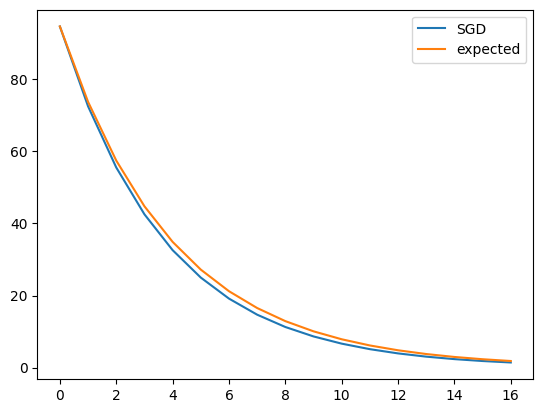

In [7]:
for i, learning_rate in enumerate(config.learning_rates):
    if i == 3:
        values = jnp.array([0.5 * x_0.T @ H @ x_0] + sampled_values[i])
        plt.plot(values, label = "SGD")
        time = jnp.arange(0.0, config.final_time + learning_rate,
                          learning_rate)
        expected_first_order_loss_value = expected_first_order_loss(
            time, x_0, H, learning_rate)
        plt.plot(expected_first_order_loss_value, label = 'expected')
plt.legend()
# plt.savefig('/home/jonathan/forest/images/sgd_weird_behavior.png')

In [8]:
A = jnp.column_stack(
    (jnp.log(jnp.array(config.final_time)), jnp.ones((len(config.final_time), ))))
log_first_order_error = jnp.log(jnp.array(first_order_error))
log_second_order_error = jnp.log(jnp.array(second_order_error))
first_order_slope, _, _, _ = jnp.linalg.lstsq(A, log_first_order_error)
second_order_slope, _, _, _ = jnp.linalg.lstsq(A, log_second_order_error)
print(first_order_slope)
print(second_order_slope)

TypeError: object of type 'float' has no len()

In [ ]:
for learning_rate, error in zip(config.learning_rates, first_order_error):
    plt.plot(learning_rate,
             error,
             'b*')
for learning_rate, error in zip(config.learning_rates, second_order_error):
    plt.plot(learning_rate,
             error,
             'r*')
t = jnp.linspace(config.learning_rates[-1], config.learning_rates[0], 1000)
y = jnp.exp(first_order_slope[1]) * t**first_order_slope[0]
plt.plot(t, y, '-', label='first order')
y = jnp.exp(second_order_slope[1]) * t**second_order_slope[0]
plt.plot(t, y, '-', label='second order')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig('/home/jonathan/forest/images/weak_order_2_SGD_fixed.png')

In [ ]:
def objective(x, gamma, Q, D):
    return 0.5 * (Q.T @ x).T @ (D + jnp.diag(gamma)) @ (Q.T @ x)

In [ ]:
@partial(jax.vmap, in_axes = (0, None, None, None))
def expected_objective(time, initial_value, learning_rate, H):
    return 0.5 * jnp.exp(learning_rate * time) * initial_value.T @ H @ linalg.expm(-2 * H * time) @ initial_value

In [ ]:
@jit
@partial(jax.vmap, in_axes=(0, 0, None, None, None))
def stochastic_gradient_update(x, gamma, Q, D, learning_rate):
    gradient = jax.grad(objective)(x, gamma, Q, D)
    updated_x = x - learning_rate * gradient
    value = 0.5 * updated_x.T @ Q @ D @ Q.T @ x
    return value, updated_x

config.number_of_samples = 10000000
config.learning_rates = 2.0**jnp.arange(-2, -8, -1)
sampled_values = [[] for i in range(len(config.learning_rates))]
for index, learning_rate in enumerate(config.learning_rates):
    max_iterations = int(config.final_time / learning_rate)
    x = jnp.tile(x_0, (config.number_of_samples, 1))
    for _ in tqdm(range(max_iterations)):
        key, subkey = random.split(key)
        normal_noise = random.normal(subkey, (config.number_of_samples, config.dimension))
        value, x = stochastic_gradient_update(x, normal_noise, H, H,
                                              learning_rate)
        sampled_values[index].append(jnp.average(value))

In [ ]:
first_order_error = []
for learning_rate, sampled_value in zip(config.learning_rates, sampled_values):
    time = jnp.arange(0.0, config.final_time, learning_rate) + learning_rate
    expected_first_order_loss_value = expected_objective(
        time, x_0, learning_rate, H)
    first_order_error.append(
        jnp.max(
            jnp.abs(
                jnp.array(sampled_value) - expected_first_order_loss_value)))
A = jnp.column_stack(
    (jnp.log(jnp.array(config.learning_rates)), jnp.ones((len(config.learning_rates), ))))
log_first_order_error = jnp.log(jnp.array(first_order_error))
first_order_slope, _, _, _ = jnp.linalg.lstsq(A, log_first_order_error)
print(first_order_slope)


In [ ]:
for learning_rate, error in zip(config.learning_rates, first_order_error):
    plt.plot(learning_rate, error, 'b*')
t = jnp.linspace(config.learning_rates[-1], config.learning_rates[0], 1000)
y = jnp.exp(first_order_slope[1]) * t**first_order_slope[0]
plt.plot(t, y, '-', label='first order')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.xscale('log')
plt.legend()